Title

Introduction

Methods and Results

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(devtools)
install.packages('GGally')
library(GGally)
install.packages("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

This Cell Loads the data set into Jupyter and cleans the column names into usable formats(ie. "Card Type" to "CardType") and changes the CardType Column from a character column to a factor column.

In [2]:
#Code Here
BankData <- read_csv("https://raw.githubusercontent.com/3deiuah/DSCI-100-Group-Project/main/Customer-Churn-Records.csv")
colnames(BankData)[17] <- "CardType"
colnames(BankData)[18] <- "PointEarned"
BankData <- mutate(BankData,CardType = as_factor(CardType))
head(BankData) #Data set loaded into R, Data Set is already Tidy

Rows: 10000 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): Surname, Geography, Gender, Card Type
dbl (14): RowNumber, CustomerId, CreditScore, Age, Tenure, Balance, NumOfPro...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


RowNumber CustomerId Surname  CreditScore Geography Gender Age Tenure
1 1         15634602   Hargrave 619         France    Female 42  2     
2 2         15647311   Hill     608         Spain     Female 41  1     
3 3         15619304   Onio     502         France    Female 42  8     
4 4         15701354   Boni     699         France    Female 39  1     
5 5         15737888   Mitchell 850         Spain     Female 43  2     
6 6         15574012   Chu      645         Spain     Male   44  8     
  Balance   NumOfProducts HasCrCard IsActiveMember EstimatedSalary Exited
1      0.00 1             1         1              101348.88       1     
2  83807.86 1             0         1              112542.58       0     
3 159660.80 3             1         0              113931.57       1     
4      0.00 2             0         0               93826.63       0     
5 125510.82 1             1         1               79084.10       0     
6 113755.78 2             1         0              149756.71       1     
  Complain Satisfaction Score CardType PointEarned
1 1        2                  DIAMOND  464        
2 1        3                  DIAMOND  456        
3 1        3                  DIAMOND  377        
4 0        5                  GOLD     350        
5 0        5                  GOLD     425        
6 1        5                  DIAMOND  484

In [3]:
BankNA <- sum(is.na(BankData))
BankNA #No NA values in the data set.

[1] 0

We then check if there are any NA values present in the data set, which there are none.

In this specific analysis, we know that certain columns in this data set are not relevant, such as the CustomerId, RowNumber and Surname columns, so this cell removes them.

In [4]:
CleanBankData <- select(BankData, -CustomerId, -RowNumber, -Surname)
head(CleanBankData)

CreditScore Geography Gender Age Tenure Balance   NumOfProducts HasCrCard
1 619         France    Female 42  2           0.00 1             1        
2 608         Spain     Female 41  1       83807.86 1             0        
3 502         France    Female 42  8      159660.80 3             1        
4 699         France    Female 39  1           0.00 2             0        
5 850         Spain     Female 43  2      125510.82 1             1        
6 645         Spain     Male   44  8      113755.78 2             1        
  IsActiveMember EstimatedSalary Exited Complain Satisfaction Score CardType
1 1              101348.88       1      1        2                  DIAMOND 
2 1              112542.58       0      1        3                  DIAMOND 
3 0              113931.57       1      1        3                  DIAMOND 
4 0               93826.63       0      0        5                  GOLD    
5 1               79084.10       0      0        5                  GOLD    
6 0              149756.71       1      1        5                  DIAMOND 
  PointEarned
1 464        
2 456        
3 377        
4 350        
5 425        
6 484

Then to perform our Exploratory Data Analysis, we split the data into training and testing data.

In [5]:
bank_split <- initial_split(CleanBankData, prop = 0.75, strata = CreditScore)
bank_train <- training(bank_split)
bank_test <- testing(bank_split)

For our analysis, we wanted to use the Balance and Points earned for a customer to try to predict their credit score, so we calculated the mean and standard deviations for these columns.

In [6]:
Mean_sd_bank <- bank_train |> select(Balance, PointEarned,CreditScore) |> summarize(mean_Balance = mean(Balance),sd_Balance = sd(Balance),mean_Point = mean(PointEarned), 
                                         sd_Point = sd(PointEarned),
                                         mean_Credit = mean(CreditScore),sd_Credit = sd(CreditScore))
Mean_sd_bank

mean_Balance sd_Balance mean_Point sd_Point mean_Credit sd_Credit
1 76685.32     62155.79   607.8365   227.2427 650.824     97.11327

While we want to use Balance and Points earned to predict Credit Score, we can visualize the relationship between these two variables to see if there is any confounding between the two variables.

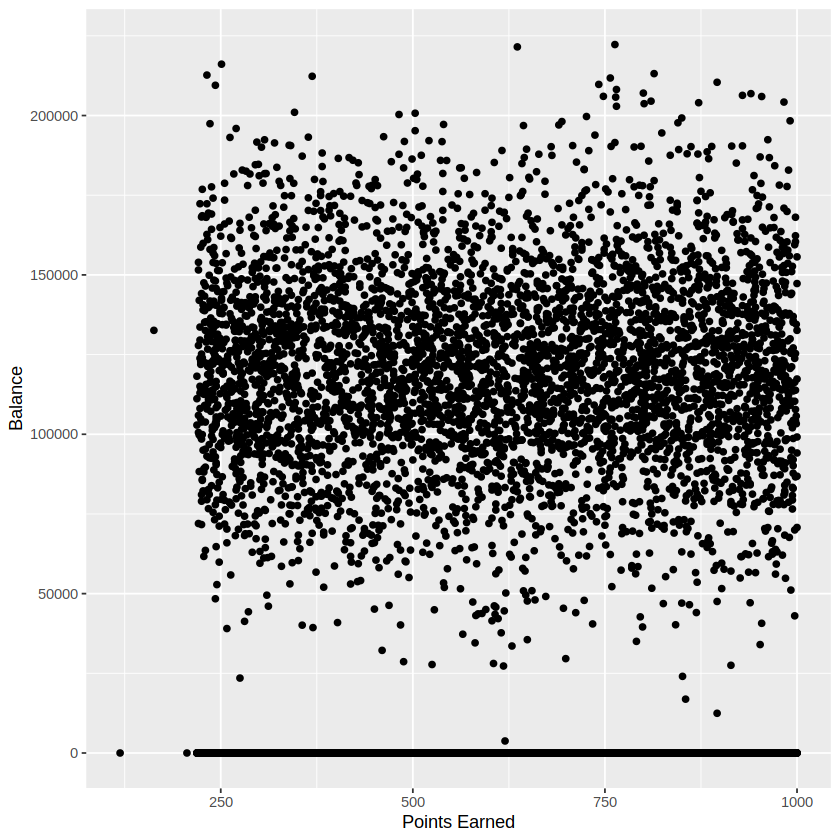

In [7]:
correlation_plot <- bank_train |> ggplot(aes(x = PointEarned,y=Balance)) + geom_point() + ylab("Balance") + xlab("Points Earned")
correlation_plot

As we can see, there is not a significant relationship between the two variables, so we can rule out any confounding.

Then we can begin the data analysis, first creating a specification for a nearest neighbor regression model.

In [8]:
bank_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |> 
       set_engine("kknn") |>
       set_mode("regression")

We can then create a recipe to specify what our model will consider to predict Credit Score

In [9]:
bank_recipe <- recipe(CreditScore ~ Balance+PointEarned, data = bank_train)

Then we can combine the specification and recipe in a workflow, then fitting the training data in as well.

In [10]:
#bank_fit <- workflow() |> add_model(Bank_spec) |> add_recipe(bank_recipe) |> fit(data = bank_train)

Visualizing this fit with the training data yields the following graph.

In [11]:
#bank_train_plot1 <- bank_fit |> predict(bank_train) |> bind_cols(bank_train) |> select(Balance,CreditScore,PointEarned,.pred) |> ggplot(aes(x=Balance,y=CreditScore)) + geom_point() + geom_line(mapping = aes(x=Balance,y=.pred),color = "blue")
#bank_train_plot1
#bank_train_plot2<-bank_fit |> predict(bank_train) |> bind_cols(bank_train) |> select(Balance,CreditScore,PointEarned,.pred) |> ggplot(aes(x=PointEarned,y=CreditScore)) + geom_point() + geom_line(mapping = aes(x=PointEarned,y=.pred),color = "blue")
#bank_train_plot2

 <- bank_fit |> predict(bank_train) |> bind_cols(bank_train) |>  metrics(truth = CreditScore, estimate = .pred) |> filter(.metric == "rmse") |>
          select(.metric, .estimator,  .estimate) |>
          pull()

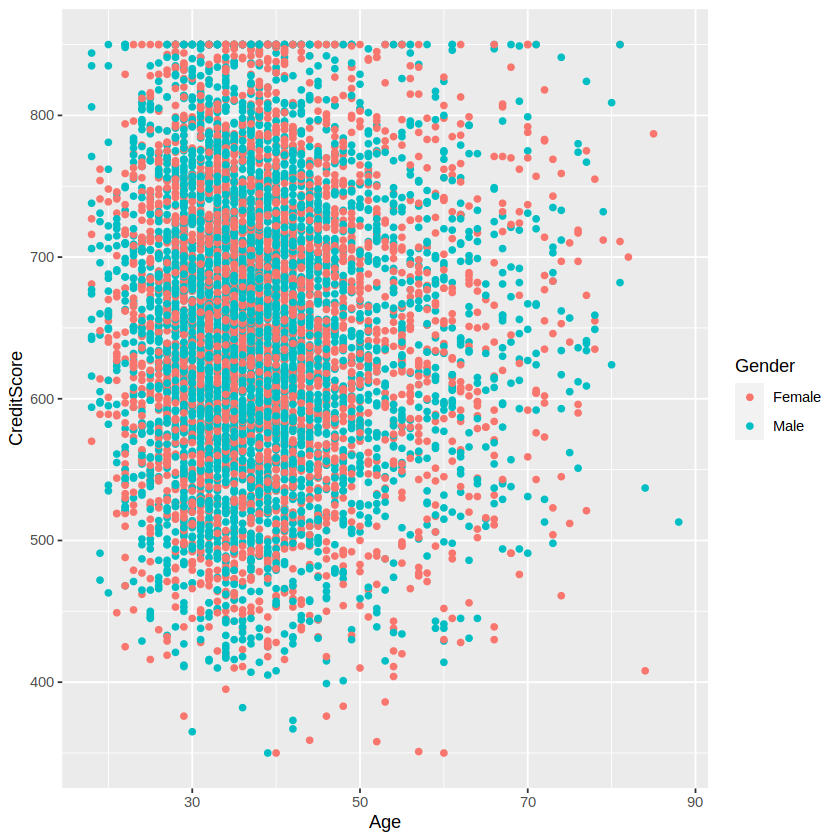

In [21]:
plot <- bank_train |> ggplot(aes(x =Age,y=CreditScore,color = Gender)) + geom_point()
plot

bank_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
       set_engine("kknn") |>
       set_mode("regression")
bank_knn_recipe <- bank_recipe |> step_scale(all_predictors()) |>
       step_center(all_predictors())
bank_vfold <- vfold_cv(bank_train,v=5,strata = CreditScore)
bank_knn_workflow <- workflow() |> add_recipe(bank_knn_recipe) |> add_model(bank_knn_spec) |> fit(data = bank_train)
gridvals <- tibble(neighbors = seq(from = 1, to = 81, by = 10))
bank_results <- bank_knn_workflow |> tune_grid(resamples = bank_vfold,grid = gridvals) |> collect_metrics() |>
    filter(.metric == "rmse") |>
    slice_min(mean, n = 1)
bank_results


In [13]:
bank_knn_plot1 <- bank_knn_workflow |> predict(bank_train) |> bind_cols(bank_train)  |>ggplot(aes(x=Balance,y=CreditScore)) + geom_point() + geom_line(mapping = aes(x=Balance,y=.pred),color = "blue")
bank_knn_plot1
bank_knn_plot2 <- bank_knn_workflow |> predict(bank_train) |> bind_cols(bank_train)  |>ggplot(aes(x=PointEarned,y=CreditScore)) + geom_point() + geom_line(mapping = aes(x=PointEarned,y=.pred),color = "blue")
bank_knn_plot2

ERROR: Error in predict(bank_knn_workflow, bank_train): object 'bank_knn_workflow' not found
